# AMAZON - Multi-label Classification 

# About the Dataset

Satellite images labelled with classes of atmospheric conditions and land cover/land usage. 

Can help differentiate between human causes and natural causes forest loss. To help better understand, track and respond to deforestation around the world.

In [ ]:
import os
import zipfile
 
import pandas as pd

In [ ]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
!kaggle datasets download nikitarom/planets-dataset -p /content
!unzip -q -n /content/planets-dataset.zip -d /content
!rm /content/planets-dataset.zip

100% 1.50G/1.50G [00:24<00:00, 108MB/s] 
100% 1.50G/1.50G [00:24<00:00, 65.7MB/s]


In [ ]:
DATA_DIR = '/content/planet/planet'
TRAIN_DIR = DATA_DIR + '/train-jpg'
TEST_DIR =  DATA_DIR + '/test-jpg'

labels_df = pd.read_csv(DATA_DIR + '/train_classes.csv')

In [ ]:
print(labels_df.shape)
print(labels_df[:5])

(40479, 2)
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


# PREVIEW IMAGES

In [ ]:
import cv2

img = cv2.imread(TRAIN_DIR + '/train_0.jpg')
print('Image dims : {}'.format(img.shape))

Image dims : (256, 256, 3)


In [ ]:
import glob
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

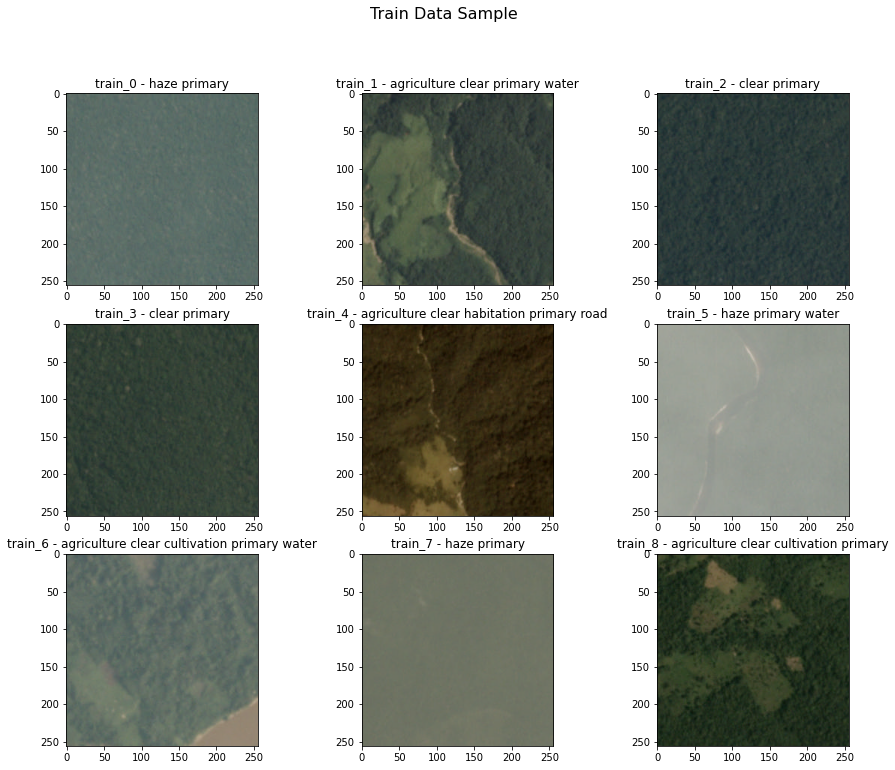

In [ ]:
fig = plt.figure(figsize=(15,12))
rows = 3
columns = 3

for i in range(9):
  path = TRAIN_DIR + '/train_' + str(i) + '.jpg'
  img = plt.imread(path)      #or cv2.imread()
  title = os.path.splitext(os.path.basename(path))[0] + ' - ' + labels_df['tags'][i]
  plt.subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.title(title)
  if i == rows*columns-1:
    plt.suptitle('Train Data Sample', fontsize=16)

# INSPECT LABELS

In [ ]:
from itertools import chain

In [ ]:
labels_list = list(chain.from_iterable([tags.split(' ') for tags in labels_df['tags'].values]))     #labels are space-delimited
print('Total number of images : {}'.format(labels_df.shape[0]))
print('Total number of labels : {}'.format(len(labels_list)))

label_set = set(labels_list) 
print('Total number of unique labels : {}'.format(len(label_set)))
print('Average number of labels per image : {}'.format(len(labels_list)/len(labels_df['tags'])))

Total number of images : 40479
Total number of labels : 116278
Total number of unique labels : 17
Average number of labels per image : 2.8725511993873365


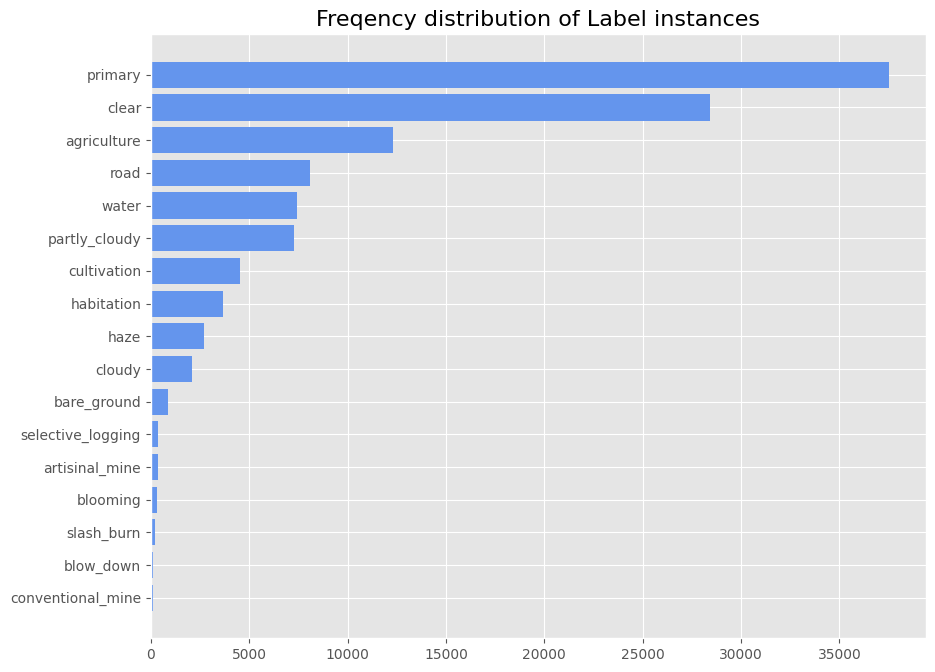

In [ ]:
labels_series = pd.Series(labels_list).value_counts(sort=True, ascending=True) #sort by frequency

plt.style.use('ggplot')     #/'default'
fig = plt.figure(figsize=(10, 8), dpi=100)
plt.barh(labels_series.index, labels_series, color='cornflowerblue')
plt.title('Freqency distribution of Label instances', fontsize=16)
fig.show()

# CO-OCCURENCE MATRIX

In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
unique_labels_sorted = labels_series.index     

matrix = np.zeros((len(unique_labels_sorted), len(unique_labels_sorted)))
tags_list = [tags.split(' ') for tags in labels_df['tags'].values]

for i, label in enumerate(unique_labels_sorted):
  for i2, label2 in enumerate(unique_labels_sorted):
    if label2 != label:
      c = 0
      for tag in tags_list:
        if label in tag:
          if label2 in tag:
            c += 1
      matrix[i, i2] = c/len(tags_list)

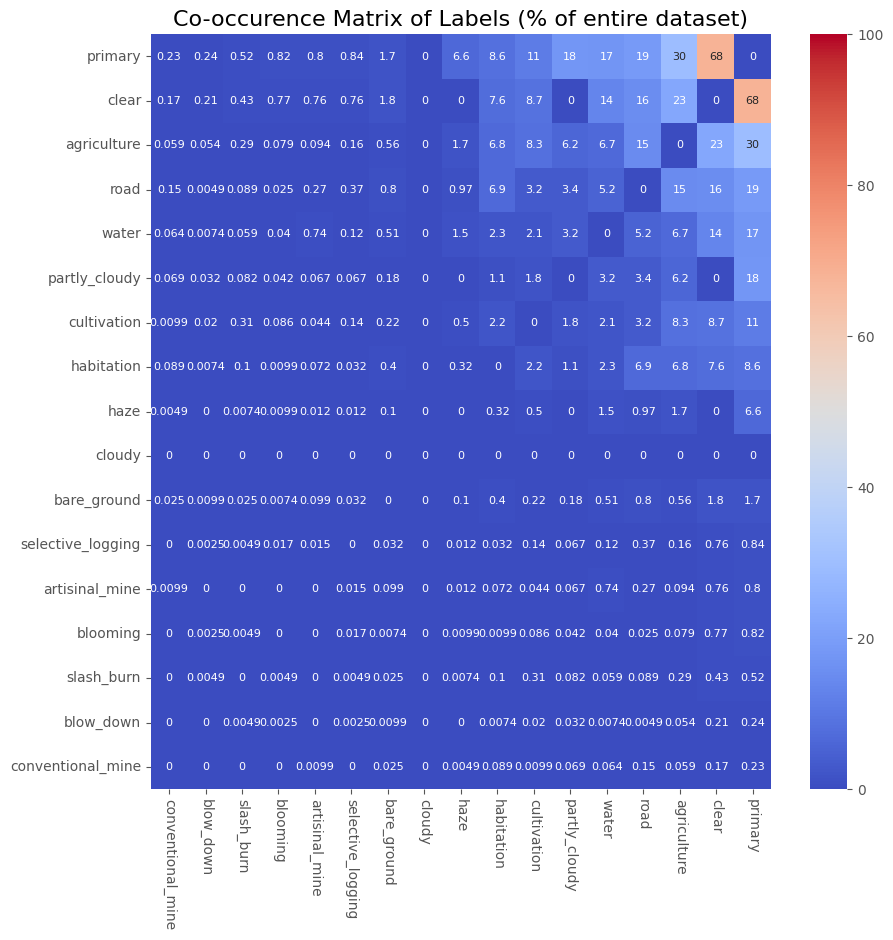

In [ ]:
plt.figure(figsize=(10,10), dpi=100)

ax = sns.heatmap(matrix*100, xticklabels=list(unique_labels_sorted), yticklabels=list(unique_labels_sorted), annot = True, annot_kws={'size':8}, fmt='.2g', vmin=0, vmax=100, cmap = 'coolwarm')
ax.invert_yaxis()
plt.xticks(rotation=-90)

plt.title('Co-occurence Matrix of Labels (% of entire dataset)', fontsize=16)
plt.show()

- 'cloudy' is an exclusive class
- 'partly cloudy' and 'clear' never co-occur
- 'primary' frequently co-occurs with other classes 
- difficult to interpret due to high class imbalance

In [ ]:
matrix = np.zeros((len(unique_labels_sorted), len(unique_labels_sorted)))
tags_list = [tags.split(' ') for tags in labels_df['tags'].values]

for i, label in enumerate(unique_labels_sorted):
  for i2, label2 in enumerate(unique_labels_sorted):
      c = 0
      cy = 0
      for tag in tags_list:
        if label in tag:
          cy += 1
          if label2 in tag:
            c += 1
      matrix[i2, i] = c/cy  

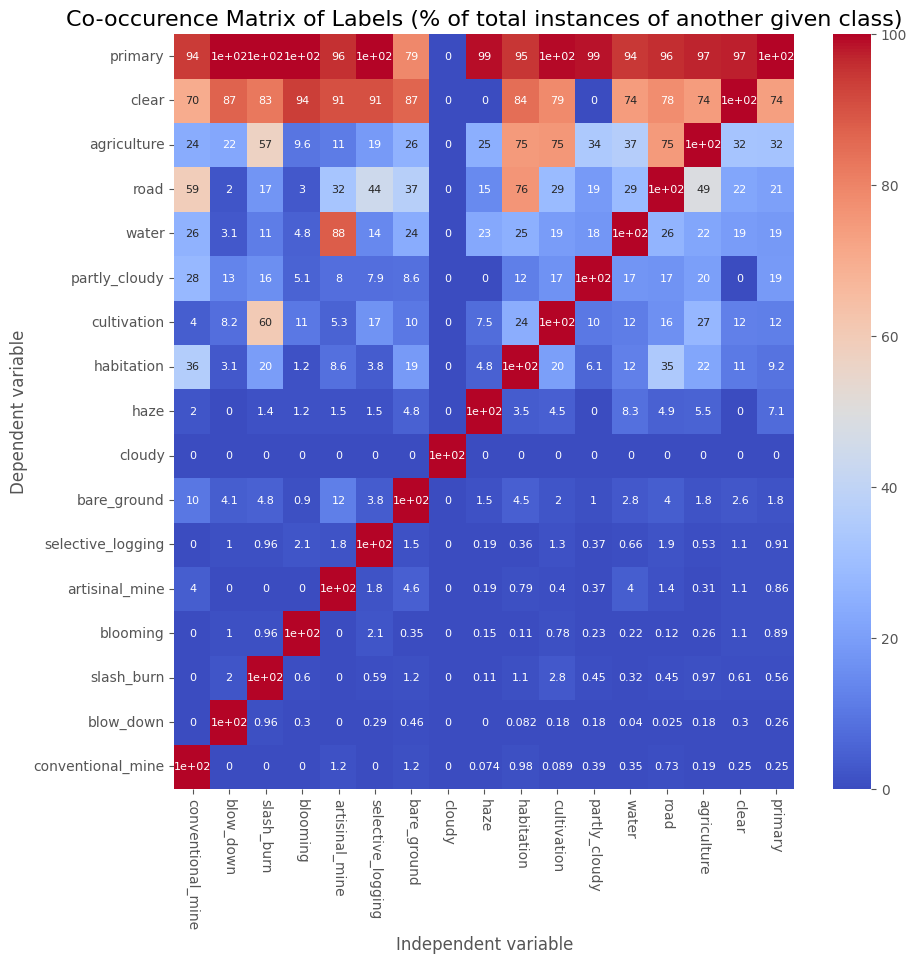

In [ ]:
plt.figure(figsize=(10,10), dpi=100)

ax = sns.heatmap(matrix*100, xticklabels=list(unique_labels_sorted), yticklabels=list(unique_labels_sorted), annot = True, annot_kws={'size':8}, fmt='.2g', vmin=0, vmax=100, cmap = 'coolwarm')
ax.invert_yaxis()
plt.xticks(rotation=-90)

plt.title('Co-occurence Matrix of Labels (% of total instances of another given class)', fontsize=16)
plt.xlabel('Independent variable')
plt.ylabel('Dependent variable')
plt.show()

# CLUSTERING / DATA VISUALIZATION WITH DIMENSIONALITY REDUCTION

In [ ]:
#import plotly.io as plt_io
import plotly.graph_objects as go
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
!pip install umap-learn
#!pip install --upgrade tbb
from umap import UMAP

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 60.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=833337b080fc687fc81af4ff0a7194fd9f883f43be6decff31c0326350c023f6
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=06eed8e230e5143d1a036b2aa80d28201d01f4e96879d056d91a2dd2593e6360
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
# subset of images to reduce computation time
imgs = []
n_imgs = 1000
img_size = 100
img_paths = glob.glob(TRAIN_DIR + '/*.jpg')[0:n_imgs]

# image preprocessing
for img_path in tqdm(img_paths, miniters=100):
    img = plt.imread(img_path)
    img = cv2.resize(img, (img_size, img_size), cv2.INTER_LINEAR).astype('float')
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)      
    imgs.append(img)

# convert to np array
x = np.vstack(imgs)
print(x.shape)      # 100x100x4

100%|██████████| 1000/1000 [00:02<00:00, 404.63it/s]

(1000, 40000)


In [ ]:
## optionally standardize the data 
##standardization of a dataset is a common requirement for many machine learning estimators
##they might behave badly if the individual features do not resemble standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)

#from sklearn.preprocessing import StandardScaler
#x = StandardScaler().fit_transform(x)
#print(x[0])

In [ ]:
def plot_2d(component1, component2, color='cornflowerblue', title=' '):

  fig = go.Figure(data=go.Scatter(x = component1,
                                  y = component2,
                                  mode='markers',
                                  marker=dict(size=10,      #or list/array
                                              color=color,      #or list/array      
                                              #colorscale=colorscale, 
                                              #showscale=True,
                                              opacity=0.8,
                                              line_width=1)
                                  ))
  fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=800,height=600,title=title)                 

  fig.show()

In [ ]:
def plot_3d(component1,component2,component3, color='cornflowerblue', title=' '):

  fig = go.Figure(data=[go.Scatter3d(x=component1,
                                    y=component2,
                                    z=component3,
                                    mode='markers',
                                    marker=dict(size=8,
                                                color=color,                
                                                #colorscale=colorscale,
                                                opacity=1,
                                                line_width=1),
                                    )])
  fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=800,height=600,title=title)

  fig.show()

In [ ]:
reducer = UMAP(n_components=3, 
               init='random', 
               random_state=0, 
               verbose=0, 
               n_neighbors=15, 
               min_dist=0.1, 
               metric='euclidean'
               #target_metric=target_metric     #unsupervised
               ) 
umap_3d = reducer.fit_transform(x)

In [ ]:
plot_3d(umap_3d[:,0],umap_3d[:,1],umap_3d[:,2], title='UMAP 3D')

Dimension reduction allows data visualization to identify clusters of that share similar features.

In [ ]:
reducer = UMAP(n_components=2, 
               init='random', 
               random_state=0, 
               verbose=0, 
               n_neighbors=15, 
               min_dist=0.1, 
               metric='euclidean'
               #target_metric=target_metric     #unsupervised
               ) 
umap_2d = reducer.fit_transform(x)

In [ ]:
y = []      #or use map()

for tags in labels_df['tags'].values[:n_imgs]:   
  if 'bare_ground' in tags and 'artisinal_mine' in tags:
    y.append('firebrick')
  elif 'bare_ground' in tags:
    y.append('darkorange')
  elif 'artisinal_mine' in tags:
    y.append('mediumaquamarine')  
  else:
    y.append('grey')

In [ ]:
plot_2d(umap_2d[:, 0],umap_2d[:, 1], title='UMAP 2D : bare_ground & artisinal_mine', color=y)

Individual classes may also be highlighted like so. Example shows 'bare_ground'(orange), 'artisinal_mine'(blue) and co-occurence(red).

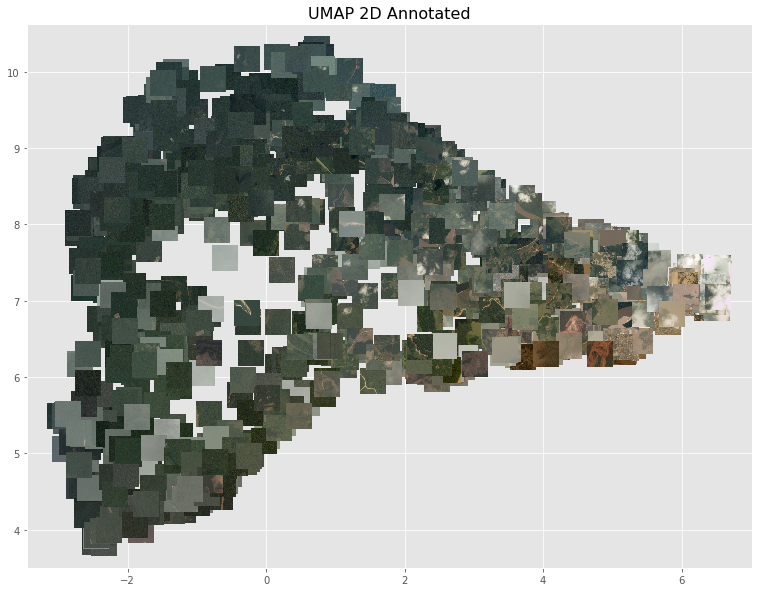

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_scatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, img in zip(x, y, images):     
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
plt.title('UMAP 2D Annotated', fontsize=16)
plot_scatter(umap_2d[:, 0], umap_2d[:, 1], [plt.imread(img_paths[i]) for i in range(n_imgs)])

In [ ]:
#using images as markers in plotly requires conversion to png, displaying image as annotation on mouseover requires an additional library

# HYPERPARAMETERS

In [ ]:
# Image input dim hyperparameter

input_size = 128     #32,64,128,256     #100,150,200

epochs = 10

split = 35000     
batch_size = 32
num_classes = len(label_set)

# PREPROCESS LABELS AND IMAGES

In [ ]:
# tf flattens images and OHE labels already

In [ ]:
#label_map = {label : i for i, label in enumerate(label_set)}
#print(label_map)

In [ ]:
##### 1     #OHE ys and convert xs to resized arrays 

## Image input dim hyperparameter
#
#input_size = 128     #32,64,128,256     #100,150,200

In [ ]:
#from tqdm import tqdm

#xs = []
#ys = []

#for filename, tags in tqdm(labels_df.values, miniters=1000):
#  img = cv2.imread(TRAIN_DIR + '/' + filename + '.jpg')
#  img_resized = cv2.resize(img, (input_size,input_size))      #resize for faster training     
#  target = np.zeros(len(unique_labels))       #OHE labels
#  for tag in tags.split(' '):
#    target[label_map[tag]] = 1
#  xs.append(img_resized)
#  ys.append(target)

In [ ]:
#print(xs[0])
#print(ys[0])

In [ ]:
##confirm pixel value range
#max_value = np.amax(xs)     
#min_value = np.amin(xs)

#print('max value in xs : {}'.format(max_value))
#print('min value in xs : {}'.format(min_value))

In [ ]:
#xs = np.array(xs, np.float32) / 255.      #can try float16 to see if faster training w/o significiant accuracy loss      #/ x_train = x_train.reshape(60000, 784).astype("float32") / 255, x_test = x_test.reshape(10000, 784).astype("float32") / 255
#ys = np.array(ys, np.uint8)

#print('xs shape : {}'.format(xs.shape))
#print('ys shape : {}'.format(ys.shape))

In [ ]:
#split = 35000      #or use tf or scikit learn library to split 
#x_train, x_valid, y_train, y_valid = (xs[:split], xs[split:], 
#                                      ys[:split], ys[split:])

In [ ]:
###### 2  #OHE ys only, training method & metrics differ

#from tqdm import tqdm

#ys = []

#for filename, tags in tqdm(labels_df.values, miniters=1000):   
#  vector = np.zeros(len(label_set))       #OHE labels
#  for tag in tags.split(' '):
#    vector[label_map[tag]] = 1
#  ys.append(vector)

#print('\n', ys[0])

In [ ]:
#df = pd.DataFrame()
#df['filenames'] = labels_df['image_name'].values
#df['ys'] = ys

#print(df[:5])
#type(df.values)
#type(list(df.values))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

tf.__version__

'2.8.2'

In [ ]:
df = pd.DataFrame()
df['filenames'] = [f + '.jpg' for f in labels_df['image_name'].values]
df['ys'] = tags_list

print(df[:5])

     filenames                                               ys
0  train_0.jpg                                  [haze, primary]
1  train_1.jpg             [agriculture, clear, primary, water]
2  train_2.jpg                                 [clear, primary]
3  train_3.jpg                                 [clear, primary]
4  train_4.jpg  [agriculture, clear, habitation, primary, road]


In [ ]:
# image augmentation
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=5,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0.05,
      zoom_range=0.05,
      horizontal_flip=True,
      vertical_flip = False,
      fill_mode='reflect')

In [ ]:
train_generator = datagen.flow_from_dataframe(
  dataframe=df[:split],
  directory=TRAIN_DIR,
  x_col='filenames',
  y_col='ys',
  batch_size=batch_size,
  shuffle=True,
  class_mode='categorical',
  target_size=(input_size,input_size)
)

valid_generator = datagen.flow_from_dataframe(
  dataframe=df[split:],
  directory=TRAIN_DIR,
  x_col='filenames',
  y_col='ys',
  batch_size=batch_size,      #can be larger for validation
  shuffle=True,
  class_mode='categorical',
  target_size=(input_size,input_size)
)

#test_generator = datagen.flow_from_dataframe()

Found 35000 validated image filenames belonging to 17 classes.
Found 5479 validated image filenames belonging to 17 classes.


# CLASS BALANCING

In [ ]:
# class balancing

labels_list_train = list(chain.from_iterable([tags.split(' ') for tags in labels_df['tags'].values[:split]]))
labels_series_train = pd.Series(labels_list_train).value_counts(sort=True, ascending=True)      #sort by frequency

class_instances_sorted = [labels_series_train[k] for i,k in enumerate(sorted(dict(labels_series_train)))]
total = sum(class_instances_sorted)     #should equal print(len(labels_list))

class_weights = {}
for i,num in enumerate(class_instances_sorted):
  class_weights[i] = round((total/num)*(1/num_classes), 8)

print(class_weights)
#print(sum(class_weights.values()))

{0: 0.55658622, 1: 20.38640974, 2: 8.13213043, 3: 20.17767517, 4: 67.18248663, 5: 0.24066021, 6: 3.23063324, 7: 64.26150895, 8: 1.51087626, 9: 1.85913799, 10: 2.52976415, 11: 0.94351402, 12: 0.18239777, 13: 0.84627238, 14: 20.04087737, 15: 34.57344341, 16: 0.91859211}


# MODEL TRAINING

In [ ]:
#callback_save = tf.keras.callbacks.ModelCheckpoint(
#    '/content/model/saved', monitor='val_accuracy', verbose=0, save_best_only=True,
#    save_weights_only=False, mode='max', save_freq='epoch')

In [ ]:
#callback_stop = tf.keras.callbacks.EarlyStopping(
#    monitor='val_loss', patience=3, restore_best_weights=False, verbose=1)

In [ ]:
#callback_lr = tf.keras.callbacks.ReduceLROnPlateau(
#    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.0001
#)

In [ ]:
#def scheduler(epoch, lr):
#    lrin=lr
#    if epoch < 2:
#     lrout=lr
#    else:
#        lrout= lr * .5
#    print ('At the start of epoch ', epoch+1, 'lr is ', lrin, ' will be set to ', lrout, ' for epoch ', epoch+2)
#    return lrout

#callback_lr_display = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
tfa.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.5 MB/s 


'0.17.1'

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',     #loss='binary_crossentropy' for multi-label classification      #keras.losses.BinaryCrossentropy()
              optimizer=RMSprop(learning_rate=0.00015),     #adam    #0.01 #learning_rate=0.0015
              metrics=['BinaryAccuracy','AUC', tfa.metrics.FBetaScore(num_classes=num_classes, beta=1.0, threshold=0.5)])     

#metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()], AUC: Approximates the AUC (Area under the curve) of the ROC or PR curves

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 128)      0         
 )                                                               
                                                        

In [ ]:
history = model.fit(    
      train_generator,
      steps_per_epoch=train_generator.samples//batch_size,  
      epochs=epochs,
      verbose=1,
      validation_data = valid_generator,
      validation_steps=valid_generator.samples//batch_size,
      class_weight=class_weights
      #callbacks = [callback_lr]
)

Epoch 1/10
1093/1093 [==============================] - 326s 278ms/step - loss: 0.8332 - binary_accuracy: 0.6693 - auc: 0.6570 - fbeta_score: 0.1978 - val_loss: 0.4825 - val_binary_accuracy: 0.8495 - val_auc: 0.7802 - val_fbeta_score: 0.1894
Epoch 2/10
1093/1093 [==============================] - 286s 261ms/step - loss: 0.4987 - binary_accuracy: 0.8552 - auc: 0.8069 - fbeta_score: 0.1860 - val_loss: 0.3099 - val_binary_accuracy: 0.8970 - val_auc: 0.8496 - val_fbeta_score: 0.1603
Epoch 3/10
1093/1093 [==============================] - 284s 259ms/step - loss: 0.4144 - binary_accuracy: 0.8930 - auc: 0.8586 - fbeta_score: 0.1831 - val_loss: 0.2546 - val_binary_accuracy: 0.9095 - val_auc: 0.8999 - val_fbeta_score: 0.1760
Epoch 4/10
1093/1093 [==============================] - 284s 260ms/step - loss: 0.3967 - binary_accuracy: 0.8980 - auc: 0.8739 - fbeta_score: 0.1859 - val_loss: 0.2600 - val_binary_accuracy: 0.9107 - val_auc: 0.9008 - val_fbeta_score: 0.1869
Epoch 5/10
1093/1093 [==========

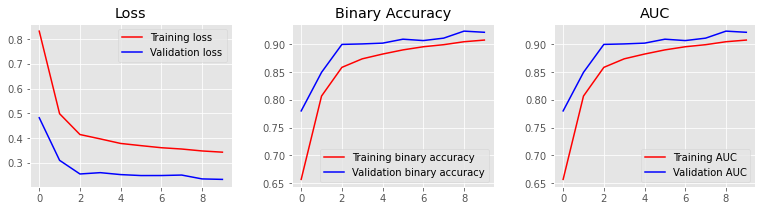

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(13, 3))

#plot acc
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.subplot(1,3,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend(loc=0)

plt.subplot(1,3,2)
plt.plot(epochs, acc, 'r', label='Training binary accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation binary accuracy')
plt.title('Binary Accuracy')
plt.legend(loc=0)


plt.subplot(1,3,3)
plt.plot(epochs, acc, 'r', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('AUC')
plt.legend(loc=0)

plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
#print(valid_generator.class_indices)      #classes are in alphabetical order

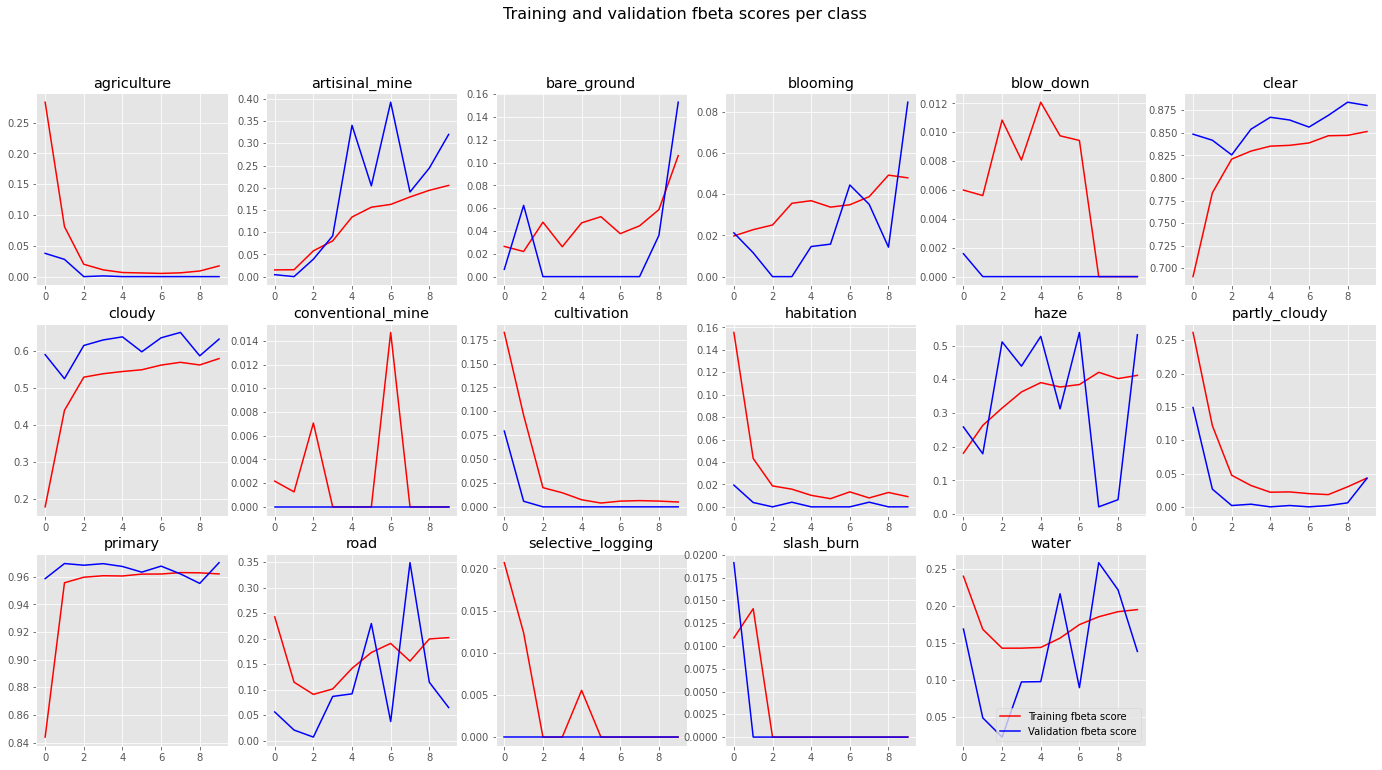

In [ ]:
fig = plt.figure(figsize=(24, 12))

def plot_fbeta(class_name, rows, cols):
  i = valid_generator.class_indices[class_name]
  plt.subplot(rows,cols,i+1)

  acc = np.array(history.history['fbeta_score'])[:,i]
  val_acc = np.array(history.history['val_fbeta_score'])[:,i]
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training fbeta score')
  plt.plot(epochs, val_acc, 'b', label='Validation fbeta score')
  plt.title(class_name)

for c in valid_generator.class_indices.keys():
  plot_fbeta(c, 3, 6)

plt.suptitle('Training and validation fbeta scores per class', fontsize=16)
plt.legend()
plt.show()

fbeta score can be misleading in imbalanced datasets or when measured in batches(stateless) rather than the entire dataset(stateful/global)

In [ ]:
#tf.keras.backend.clear_session()
#train_generator.reset()
#valid_generator.reset()

# MODEL EVALUATION

In [ ]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

In [ ]:
#arbitrary use of validation data as test data

valid_generator.reset()      #re-using generator, so need to reset to avoid output being in a different order

pred = model.predict(valid_generator, verbose=1)

threshold_bool = (pred > 0.5)

172/172 [==============================] - 33s 189ms/step


In [ ]:
print(pred.shape)
print(pred[:1])
y_pred = threshold_bool.astype(int)   
print(y_pred[:1])

(5479, 17)
[[0.15822728 0.05414373 0.24980402 0.17890681 0.07650799 0.7920216
  0.07397262 0.01738536 0.07878762 0.04471971 0.0638715  0.13630253
  0.8739716  0.12538275 0.01280674 0.00832561 0.14656864]]
[[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]]


In [ ]:
print(valid_generator.classes[:5])

[[8, 10, 12, 15], [0, 5, 12, 13], [0, 5, 8, 12, 16], [5, 12, 13, 14], [5, 12]]


In [ ]:
#print(valid_generator.class_indices)      #print for reference

In [ ]:
y_true = []     #OHE labels

for filename, tags in labels_df.values[split:]:   
  vector = np.zeros(len(label_set))   
  for tag in tags.split(' '):
    vector[valid_generator.class_indices[tag]] = 1
  y_true.append(vector)

y_true = np.array(y_true, dtype=np.int32)
print('y_true sample: ', '\n', y_true[:5])
print('y_pred sample: ', '\n', y_pred[:5])

y_true sample:  
 [[0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]]
y_pred sample:  
 [[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]]


In [ ]:
print(y_true.shape)
print(y_pred.shape)

(5479, 17)
(5479, 17)


In [ ]:
# multilabel confusion matrix

cm = tfa.metrics.MultiLabelConfusionMatrix(num_classes=num_classes)     #(0,0): true negative, (0,1): false positive, (1,0): false negative, (1,1): true positive 
cm.update_state(y_true, y_pred)
result = cm.result()
print('confusion matrixes: ', '\n', result)

confusion matrixes:  
 tf.Tensor(
[[[3.786e+03 0.000e+00]
  [1.693e+03 0.000e+00]]

 [[5.065e+03 3.650e+02]
  [4.600e+01 3.000e+00]]

 [[5.272e+03 7.200e+01]
  [1.330e+02 2.000e+00]]

 [[5.227e+03 2.130e+02]
  [3.900e+01 0.000e+00]]

 [[5.466e+03 0.000e+00]
  [1.300e+01 0.000e+00]]

 [[3.820e+02 1.232e+03]
  [9.080e+02 2.957e+03]]

 [[4.776e+03 4.440e+02]
  [2.330e+02 2.600e+01]]

 [[5.471e+03 0.000e+00]
  [8.000e+00 0.000e+00]]

 [[4.856e+03 0.000e+00]
  [6.230e+02 0.000e+00]]

 [[4.999e+03 0.000e+00]
  [4.800e+02 0.000e+00]]

 [[5.042e+03 7.700e+01]
  [3.560e+02 4.000e+00]]

 [[4.470e+03 1.400e+01]
  [9.900e+02 5.000e+00]]

 [[4.200e+01 3.370e+02]
  [5.810e+02 4.519e+03]]

 [[4.263e+03 1.310e+02]
  [1.056e+03 2.900e+01]]

 [[5.434e+03 0.000e+00]
  [4.500e+01 0.000e+00]]

 [[5.441e+03 0.000e+00]
  [3.800e+01 0.000e+00]]

 [[4.024e+03 4.800e+02]
  [8.840e+02 9.100e+01]]], shape=(17, 2, 2), dtype=float32)


In [ ]:
# transpose
result = np.array(result, dtype=np.float32)     
result = [np.transpose(cm) for cm in result]     

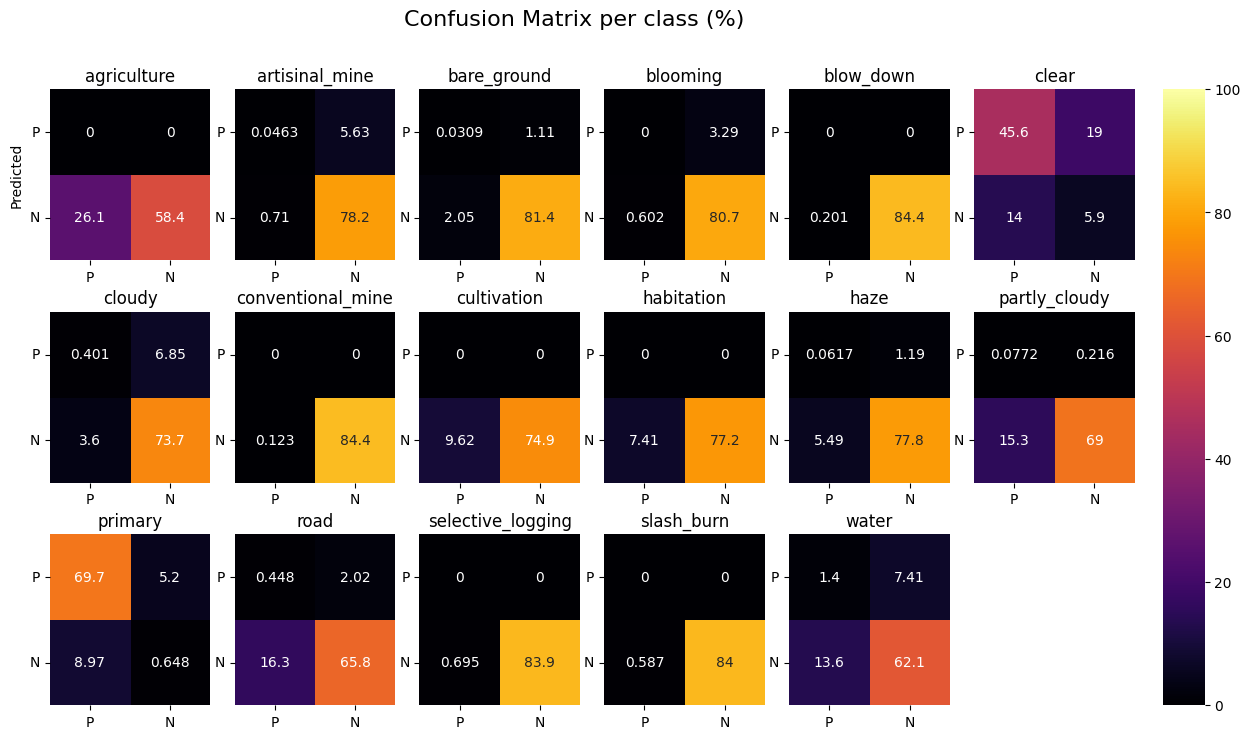

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14,8))

cbar_ax = fig.add_axes([.92, .11, .03, .77])

def plot_cm(i, class_name, cm, rows, cols):
  plt.subplot(rows,cols,i+1)
  ax = sns.heatmap(cm*100/6479, xticklabels=['N','P'], yticklabels=['N','P'], annot = True, fmt='.3g', vmin=0, vmax=100, cmap = 'inferno', cbar= (True if i==16 else False), cbar_ax=cbar_ax)
  ax.invert_xaxis()
  ax.invert_yaxis()
  plt.yticks(rotation=0)       #was changed from default earlier
  plt.title(class_name)
  if i==0:
    plt.ylabel('Predicted')

inverse = {i:k for i,k in enumerate(valid_generator.class_indices)}
for i,cm in enumerate(result):
  class_name = inverse[i]
  plot_cm(i, class_name, cm, 3, 6)

plt.suptitle('Confusion Matrix per class (%)', fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

In [ ]:
print(fbeta_score(y_true, y_pred, average='weighted', beta=1.0))      

0.48669129822468543


Potential updates:
 - include supervised dim reduction, eg. LDA (linear)
 - explore libraries that allow plotting images onto 3d space or display image on mousehover


 - compute optimal thresholds per class
 - other methods of addressing class imbalance: 
   - can try class mode 'sparse'
   - can try 'sample_weight' in tf api instead of 'class_weight' 
   - can try custom weighted binary_cross entropy loss function, multi-label-classification-with-class-weights-in-keras
 - can try macro soft f1 loss, eliminates the need to optimize threshold value after training: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72
 - further explore metrics for multi-label classification 


 - explore further options for preprocessing images: haze removal, contrast enhancement, image segmentation
 - adjust dataset: inspect outliers/maximally dissimilar images, eg. artifacts


 - explore computed parameter optimization: tf tuner, optuna, (bayesian optimization)
 - explore ensemble networks, allows selecting the most successful model for each label  
 - explore ridge regression, adds reguarlization penalty to loss function, reduces issues of multicollinearity, adjusts output to take advantage of label correlations (does not do variable selection)
 - try differing learnings rates for each individual layer in transfer learning
 - can try train atmospheric and land usage/cover classes seperately